In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Extract HRRR data using Unidata's Siphon package

In [2]:
# Resolve the latest HRRR dataset
from siphon.catalog import get_latest_access_url

hrrr_catalog = "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml"
latest_hrrr_ncss = get_latest_access_url(hrrr_catalog, "NetcdfSubset")

# Set up access via NCSS
from siphon.ncss import NCSS
ncss = NCSS(latest_hrrr_ncss)

# Create a query to ask for all times in netcdf4 format for
# the Temperature_surface variable, with a bounding box centered
# on lat,lon with a height and width speficied in degrees.
query = ncss.query()
lat = 40
lon = -105
width = 20
height = 20

In [3]:
query.all_times().accept('netcdf4').variables('Temperature_height_above_ground')
query.lonlat_box(north=lat+height/2., south=lat - height/2., east=lon + width/2., west=lon - width/2.)

# get the data!
nc = ncss.get_data(query)

## What exactly did we get from NCSS?

In [4]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/HRRR/CONUS_2p5km/HRRR_CONUS_2p5km_20160408_0000.grib2.ncx3#LambertConformal_1377X2145-38p22N-95p43W; Translation Date = 2016-04-08T02:18:39.406Z
    geospatial_lat_min: 28.7212793154
    geospatial_lat_max: 50.9440086543
    geospatial_lon_min: -119.2532687
    geospatial_lon_max: -94.9841190996
    dimensions(sizes): time2(16), height_above_ground1(1), y(961), x(760)
    variables(dimensions): float32 Temperature_height_above_ground(time2,height_abo

In [5]:
var='Temperature_height_above_ground'
ncvar = nc[var]
ncvar

<class 'netCDF4._netCDF4.Variable'>
float32 Temperature_height_above_ground(time2, height_above_ground1, y, x)
    long_name: Temperature @ Specified height level above ground
    units: K
    abbreviation: TMP
    missing_value: nan
    grid_mapping: LambertConformal_Projection
    coordinates: time2 height_above_ground1 y x 
    Grib_Variable_Id: VAR_0-0-0_L103
    Grib2_Parameter: [0 0 0]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Temperature
    Grib2_Parameter_Name: Temperature
    Grib2_Level_Type: Specified height level above ground
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (16, 1, 961, 760)
filling on, default _FillValue of 9.969209968386869e+36 used

In [6]:
grid = nc[ncvar.grid_mapping]
grid

<class 'netCDF4._netCDF4.Variable'>
int32 LambertConformal_Projection()
    grid_mapping_name: lambert_conformal_conic
    latitude_of_projection_origin: 25.0
    longitude_of_central_meridian: 265.0
    standard_parallel: 25.0
    earth_radius: 6371229.0
    _CoordinateTransformType: Projection
    _CoordinateAxisTypes: GeoX GeoY
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

In [7]:
lon0 = grid.longitude_of_central_meridian
lat0 = grid.latitude_of_projection_origin
lat1 = grid.standard_parallel
earth_radius = grid.earth_radius

## Try plotting the LambertConformal data with Cartopy

In [8]:
import cartopy
import cartopy.crs as ccrs

In [9]:
#cartopy wants meters, not km
x = nc["x"][:]*1000.
y = nc["y"][:]*1000.

In [10]:
#globe = ccrs.Globe(ellipse='WGS84') #default
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)

crs = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, 
                            standard_parallels=(lat0,lat1), globe=globe)

In [11]:
print(x.shape)
print(y.shape)
print(ncvar.shape)

(760,)
(961,)
(16, 1, 961, 760)


## Time is always fun. Let's convert it into a python `datetime` object

In [12]:
from netCDF4 import num2date
# find the correct time dimension name
for d in ncvar.dimensions:
    if "time" in d: 
        timevar = d

time = num2date(nc[timevar][:],nc[timevar].units)
time[6]

datetime.datetime(2016, 4, 8, 6, 0)

## Visualize the grid at forecast time = 0

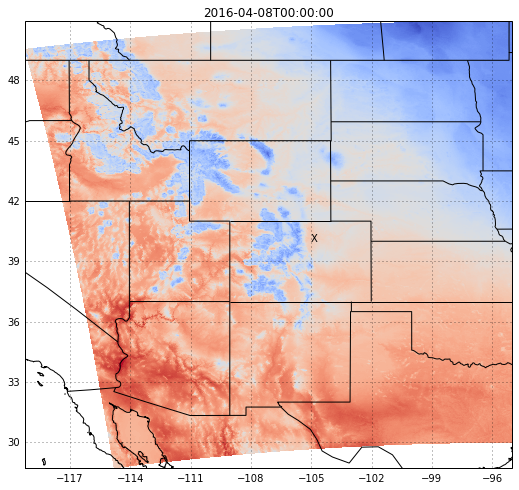

In [13]:
t_step = 0

import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = ax.pcolormesh(x,y,ncvar[t_step,::].squeeze(), transform=crs,zorder=0, cmap=plt.get_cmap("coolwarm"))
ax.text(lon, lat, "X", transform=ccrs.Geodetic())
ax.coastlines(resolution='10m',color='black',zorder=1)
ax.add_feature(states_provinces, edgecolor='black', zorder=1)
ax.add_feature(cartopy.feature.BORDERS)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title(time[t_step].isoformat());

# TODO: This is to workaround a bug in cartopy 0.14
from matplotlib.transforms import Bbox
if hasattr(mesh, '_corners'): mesh._corners = Bbox(mesh._corners)


## Things to consider/do

- Choose a new location and change the width and height of the bounding box.
- How would you go about changing the units of the temperature to, say, degC?
 - What are the units, anyways?


## Create a Skew-T diagram for the (lon,lat) location and time step previously specified

## Request profile data from the HRRR

In [14]:
point_query = ncss.query()
point_query.all_times()
point_query.accept('netcdf4')
point_query.variables('Temperature_isobaric', 'Dewpoint_temperature_isobaric')
point_query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
point_query.lonlat_point(lon, lat)

# get the data!
ncp = ncss.get_data(point_query)

## Skew-T diagrams typical use speficic units. First, let's assign units to the variables we requested

In [15]:
from metpy.units import units

p = ncp["isobaric"][:].squeeze()[t_step,:] * units.Pa
T = ncp["Temperature_isobaric"][:].squeeze()[t_step,:]  * units.K
Td = ncp["Dewpoint_temperature_isobaric"][:].squeeze()[t_step,:] * units.K
u = ncp["u-component_of_wind_isobaric"][:].squeeze()[t_step,:] * units.meter / units.second
v = ncp["v-component_of_wind_isobaric"][:].squeeze()[t_step,:] * units.meter / units.second

## Now, let's change those units to what we typically see used in Skew-T diagrams

In [16]:
p = p.to(units.millibar)
T = T.to(units.degC)
Td = Td.to(units.degC)
u = u.to(units.knot)
v = v.to(units.knot)

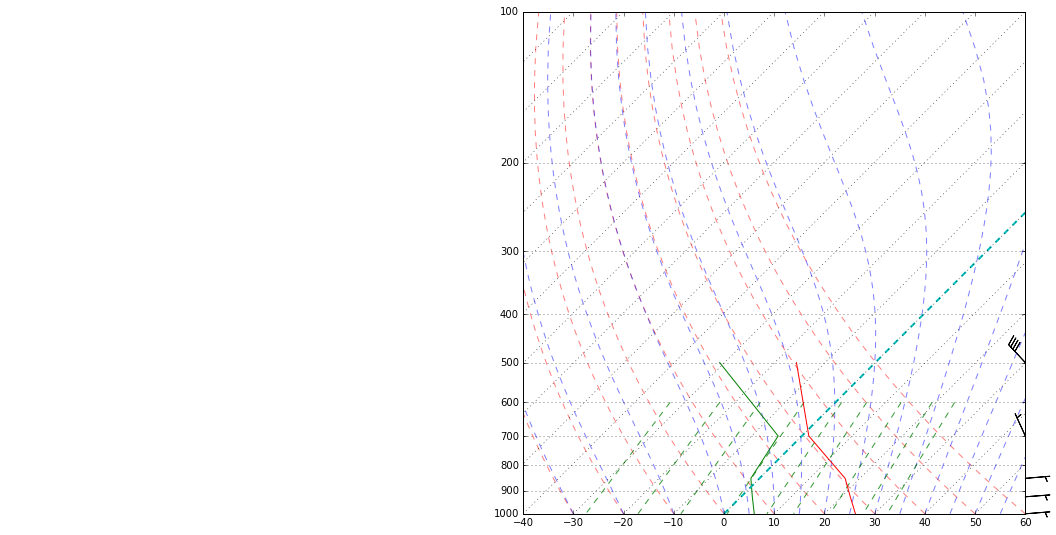

In [17]:
from metpy.calc import lcl, dry_lapse, parcel_profile
from metpy.plots import SkewT
from metpy.units import concatenate

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot
#l = lcl(p[0], T[0], Td[0])
#lcl_temp = dry_lapse(concatenate((p[0], l)), T[0])[-1].to('degC')
#skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')
#skew.plot(p, prof, 'k', linewidth=2)

# Example of coloring area between profiles
#skew.ax.fill_betweenx(p, T, prof, where=T>=prof, facecolor='blue', alpha=0.4)
#skew.ax.fill_betweenx(p, T, prof, where=T<prof, facecolor='red', alpha=0.4)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

## Things to consider/do

- Why does this Skew-T only go up to 500 mb?
- What happens if you uncomment the calculations above? Why?
